In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla

%config InlineBackend.figure_format = 'retina'

<h3>Differential Equation:</h3>
$$
u_{xx} - x^2u = -e^{\frac{-x^2}{2}}
$$

<h3> Boundary conditions:</h3>
$$
u(-9) = u(9) = 0 
$$

Using a change of coordinates, 
$$
y = \frac{x}{9} \\
u_{yy} - 6561y^2u = -81e^{\frac{-81y^2}{2}}
$$

With the boundary conditions
$$
u(-1) = u(1) = 0
$$

<h3> Chebyshev grid

In [11]:
# Chebyshev grid
N = 20 # no. of basis functions
nn = np.arange(N)
x = np.cos(np.pi*nn/(N-1))

In [13]:
# Boundary conditions
alpha = 0
beta = 0

# Coefficients of the ode
f1 = - 6561*(x**2)
f2 = -81*np.exp(-0.5*81*(x**2))

<h3> Chebyshev Polynomials and differentiation matrix</h3>
Chebyshev Polynomial
$$
T_{n+2} = 2xT_{n+1} - T_n
$$

Chebyshev kth derivative for nth basis function

$$
\frac{d^kT_{n+2}}{dx^k} =  2k\frac{d^{k-1}T_{n+1}}{dx^{k-1}} + 2x\frac{d^kT_{n+1}}{dx^k} - \frac{d^kT_{n}}{dx^k}
$$

In [15]:
# Chebyshev Polynomials
T = np.zeros((N,N))

T[0,:] = 1
T[1,:] = [x[q] for q in range(N)]

for n in range(N-2):
    T[n+2,:] = [(2*x[j]*T[n+1,j] - T[n,j]) for j in range(N)]  
    
# Chebyshev differentiation matrix
# dT1 = 1st derivative
# dT2 = 2nd derivative

dT1 = np.zeros((N,N))
dT2 = np.zeros((N,N))

dT1[0,:] = np.zeros((N))
dT2[0,:] = np.zeros((N))

dT1[1,:] = np.ones((N))
dT2[1,:] = np.zeros((N))

for n in range(N-2):
    dT1[n+2,:] = [(2*T[n+1,j] +   2*x[j]*dT1[n+1,j] - dT1[n,j]) for j in range(N)]
    dT2[n+2,:] = [(4*dT1[n+1,j] + 2*x[j]*dT2[n+1,j] - dT2[n,j]) for j in range(N)]

<h3>Matrix Discretization </h3>

We approximate $u(x)$ as
$$
u(x) = \sum_{j=1}^{N}(a_jT_{j-1}(x))
$$

Then, we can write the differential equation as:
$$
\bar{\bar{L}}.\bar{a} = \bar{F}
$$

where $\bar{\bar{L}}$ is the differential operator, $\bar{a}$ is the chebyshev coefficients and $\bar{F}$ is the right hand side forcing term.

In [16]:
# Preallocation for matrix discretization
L = np.zeros((N,N))
a = np.zeros((N))
F = np.zeros((N))

# Matrix L for the differential operator
for n in range(N):
    for j in range(N):
        L[n,j] = dT2[j,n] + f1[n]*T[j,n]
        F[n] = f2[n]
        
# Boundary conditions at t = pi and 0; x = -1 and 1
T1 = np.array([np.cos(i*0) for i in range(N)])
Tn1 = np.array([np.cos(i*np.pi) for i in range(N)])

L[0,:] = T1;       F[0] = alpha
L[N-1,:] = Tn1;      F[N-1] = beta

<h3> Direct Pseudospectral Solution

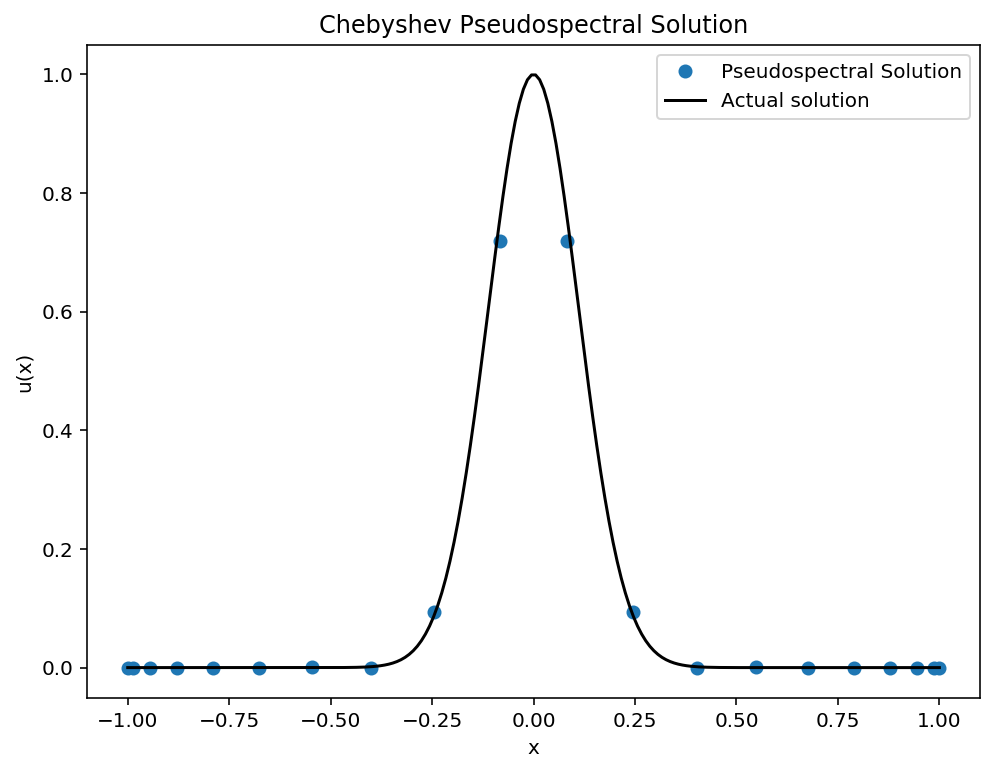

In [18]:
A = np.dot(np.linalg.inv(L), F)

# Actual Solution
x2 = np.linspace(-1,1,10*N)
u2 = np.exp(-81*0.5*x2**2)

# interpolated solution
u_int = np.dot(T,A)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(x, u_int, 'o', label='Pseudospectral Solution')
ax.plot(x2, u2, color='black', label='Actual solution')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Chebyshev Pseudospectral Solution')
ax.legend()
plt.show()

<h3> Solution using MRR with Finite Difference Preconditiong

In [19]:
# Finite Difference Preconditiong Matrix
H = np.zeros(L.shape)

# Solution at different steps: uo = u(x-h), u1 = u(x), u2 = u(x+h)
uo = -1
u1 = 0
u2 = 0

# the delta h term in finite differences
ho = 0
h1 = 0

x2 = x[::-1] # because my original chebyshev grid is from [1,-1]

for i in range(1,N-1):

    ho = x2[i] - x2[i-1]
    h1 = x2[i+1] - x2[i]
    
    Ao = (2/(ho*(ho + h1))) 
    A1 = - (2/(ho*h1))  
    A2 = (2/(h1*(ho + h1)))
    
    H[i, i-1] = Ao
    H[i,i] = A1
    H[i,i+1] = A2

#Trivial Boundary conditions
H[0,0] = - (2/((x2[1] - x2[0])*(x2[2] - x2[1])))
H[0,1] = (2/((x2[2] - x2[1])*((x2[1] - x2[0]) + (x2[2] - x2[1]))))

H[N-1,N-2] = (2/((x2[N-2] - x2[N-3])*((x2[N-2] - x2[N-3]) + (x2[N-1] - x2[N-2]))))
H[N-1,N-1] = - (2/((x2[N-2] - x2[N-3])*(x2[N-1] - x2[N-2])))

In [29]:
# Minimum Residual Richardson iteration 
k = 30

L2 = np.dot(L, L.T) # to make the matrix positive definite

# New equation Au = g from Lu = f
# A = H^-1*L; g = H^-1*F
A = np.dot(np.linalg.inv(H),L2)
g = np.dot(np.linalg.inv(H), F)

# solution
uo = g
ui = g

# residual
ro = g - np.dot(A, uo)
ri = np.zeros((N))

res = np.zeros((k))

zo = np.dot(np.linalg.inv(H), ro)
zi = np.zeros((N))

for i in range(k):
    
    lamb = np.dot(A, zo) # temporary
    tau = np.dot(ro, lamb)/np.dot(lamb, lamb)
    
    ui = uo + tau*zo
    ri = ro - tau*np.dot(A, zo)
    
    zi = np.dot(np.linalg.inv(H), ri)
    
    res[i] = np.linalg.norm(ri)
    
    # update solutions
    uo = ui
    ro = ri
    zo = zi

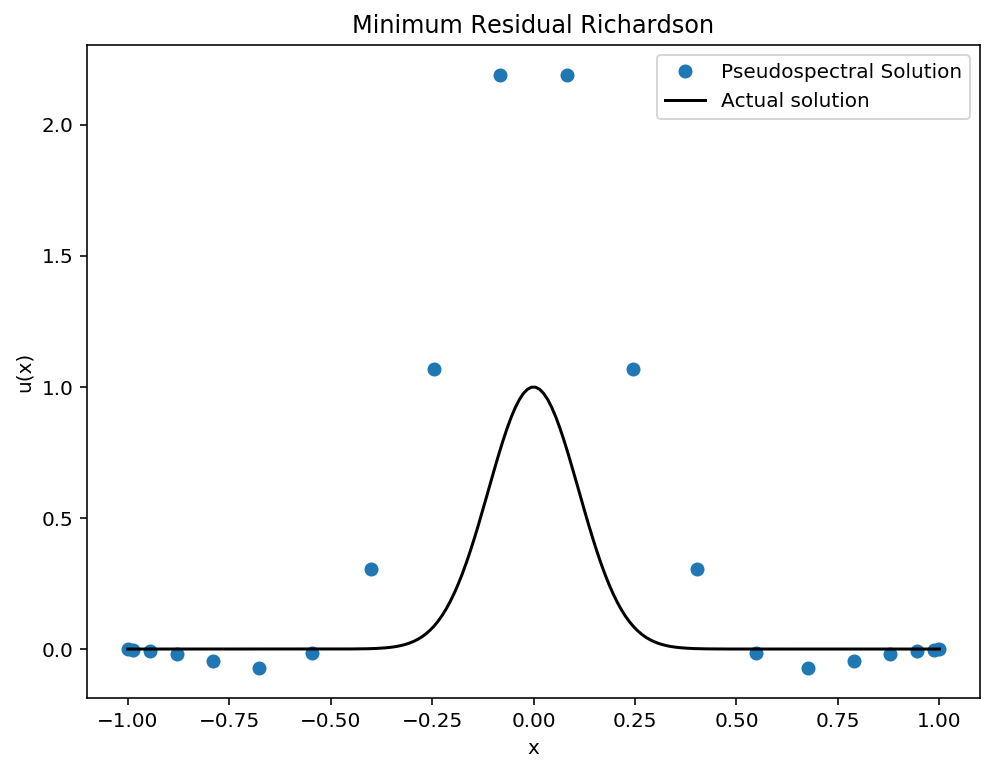

In [30]:
# actual solution
x2 = np.linspace(-1,1,10*N)
u2 = np.exp(-81*0.5*x2**2)

# interpolated solution
u = np.dot(T, ui)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(x, ui, 'o', label='Pseudospectral Solution')
ax.plot(x2, u2, color='black', label='Actual solution')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Minimum Residual Richardson')
ax.legend()
plt.show()

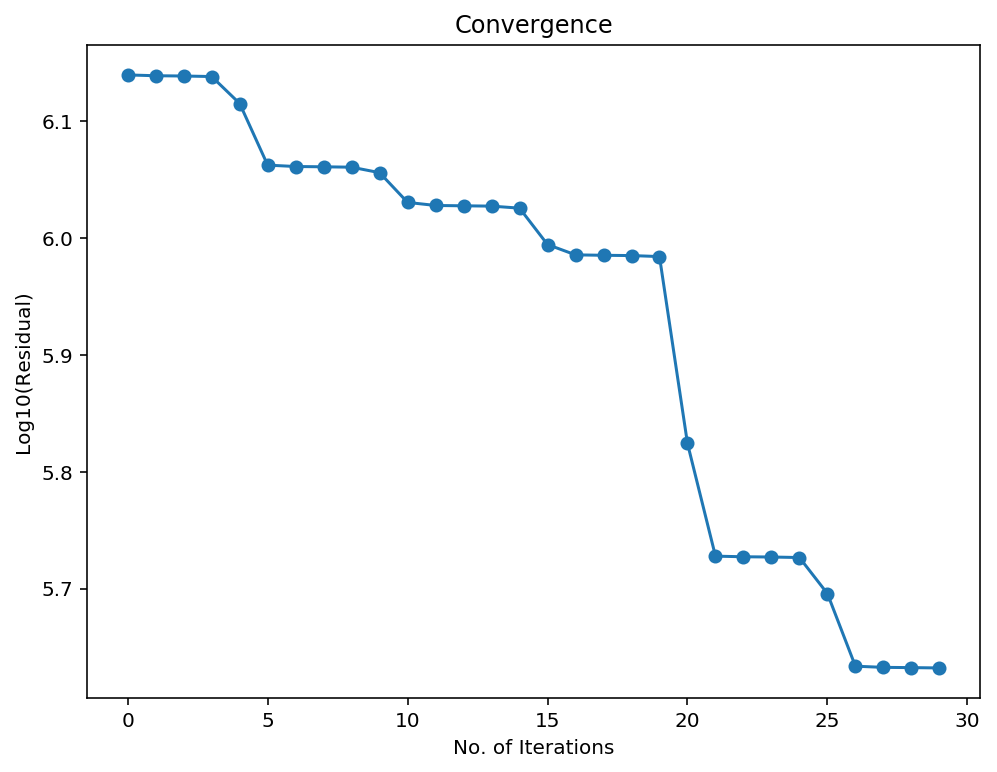

In [31]:
# Convergence Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(np.arange(k), np.log10(res), 'o-')
ax.set_xlabel('No. of Iterations')
ax.set_ylabel('Log10(Residual)')
ax.set_title('Convergence')
plt.show()